# Data Exploration of Water Level of the Rhine

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [227]:
data = pd.read_csv('data/Kaub_Level_Since_2013.csv')

In [228]:
print(data.head())

         date  level
0  2013-01-01    510
1  2013-01-02    461
2  2013-01-03    414
3  2013-01-04    378
4  2013-01-05    351


In [229]:
print(data.tail())

            date  level
3219  2021-10-23    117
3220  2021-10-24    105
3221  2021-10-25     93
3222  2021-10-26     85
3223  2021-10-27     82


In [230]:
print(data.describe(), '\n')

             level
count  3224.000000
mean    206.495658
std     102.425145
min      20.000000
25%     139.000000
50%     187.000000
75%     253.000000
max     713.000000 



In [231]:
print(data.isna().any(), '\n')

date     False
level    False
dtype: bool 



Show the timeseries data and use Linear Regression to recognize a trend in data

m is: -0.012579379122448381; b is: 226.7673270240638


<Figure size 1152x648 with 0 Axes>

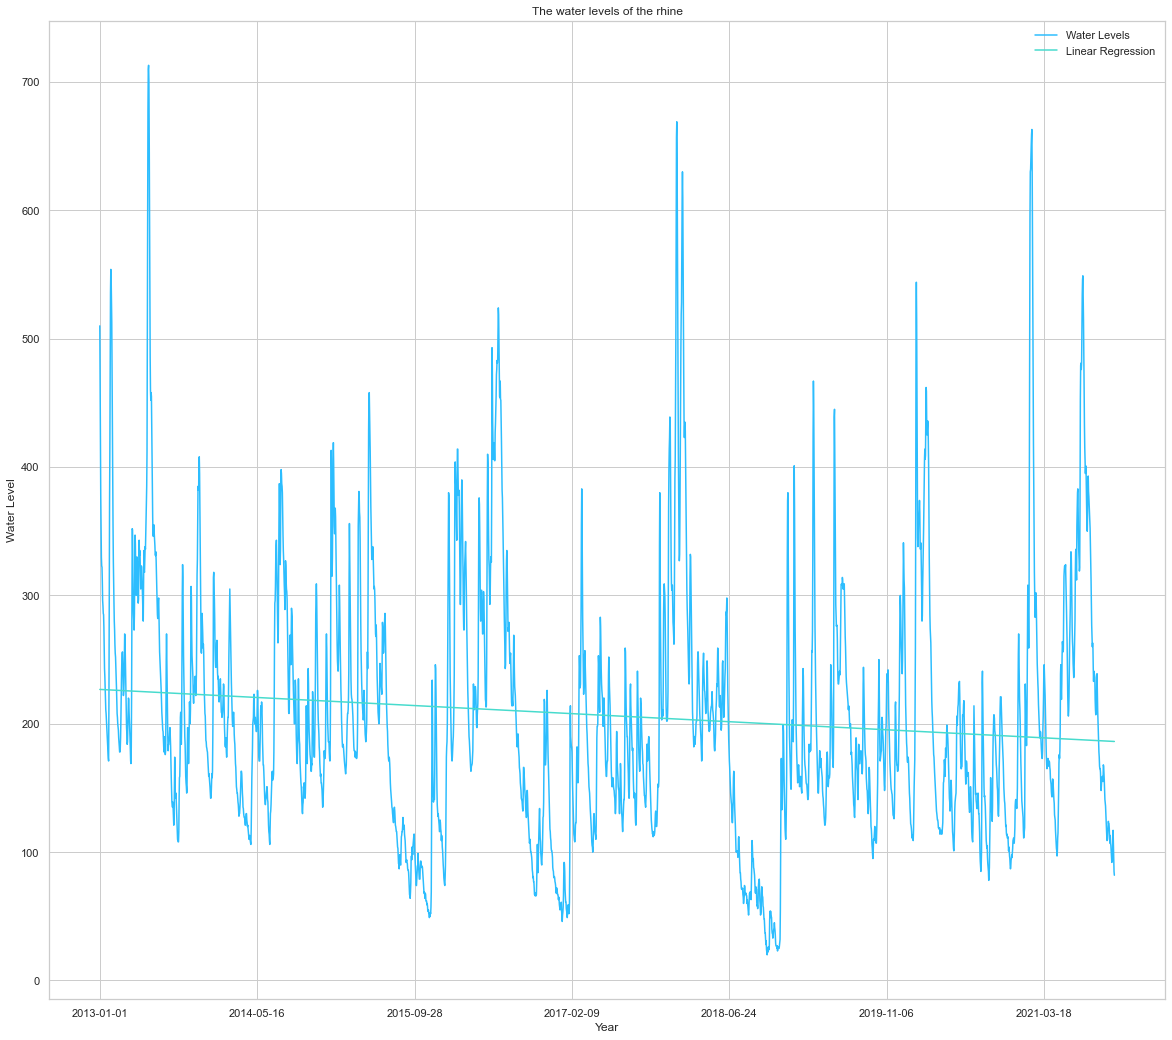

In [232]:
plt.figure(1, figsize=(16,9))
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
color_list = [CB91_Blue, CB91_Green]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
data.plot(x='date', y='level')
m, b = np.polyfit(np.arange(len(data.index)), data['level'], 1)
plt.plot(np.arange(len(data.index)), m * np.arange(len(data.index)) + b)
plt.xlabel('Year')
plt.ylabel('Water Level')
plt.title('The water levels of the rhine')
plt.legend(['Water Levels', 'Linear Regression'], frameon=False)
print('m is: {}; b is: {}'.format(m, b))

In [233]:
result_add = seasonal_decompose(x=data['level'], model='additive', period=91)

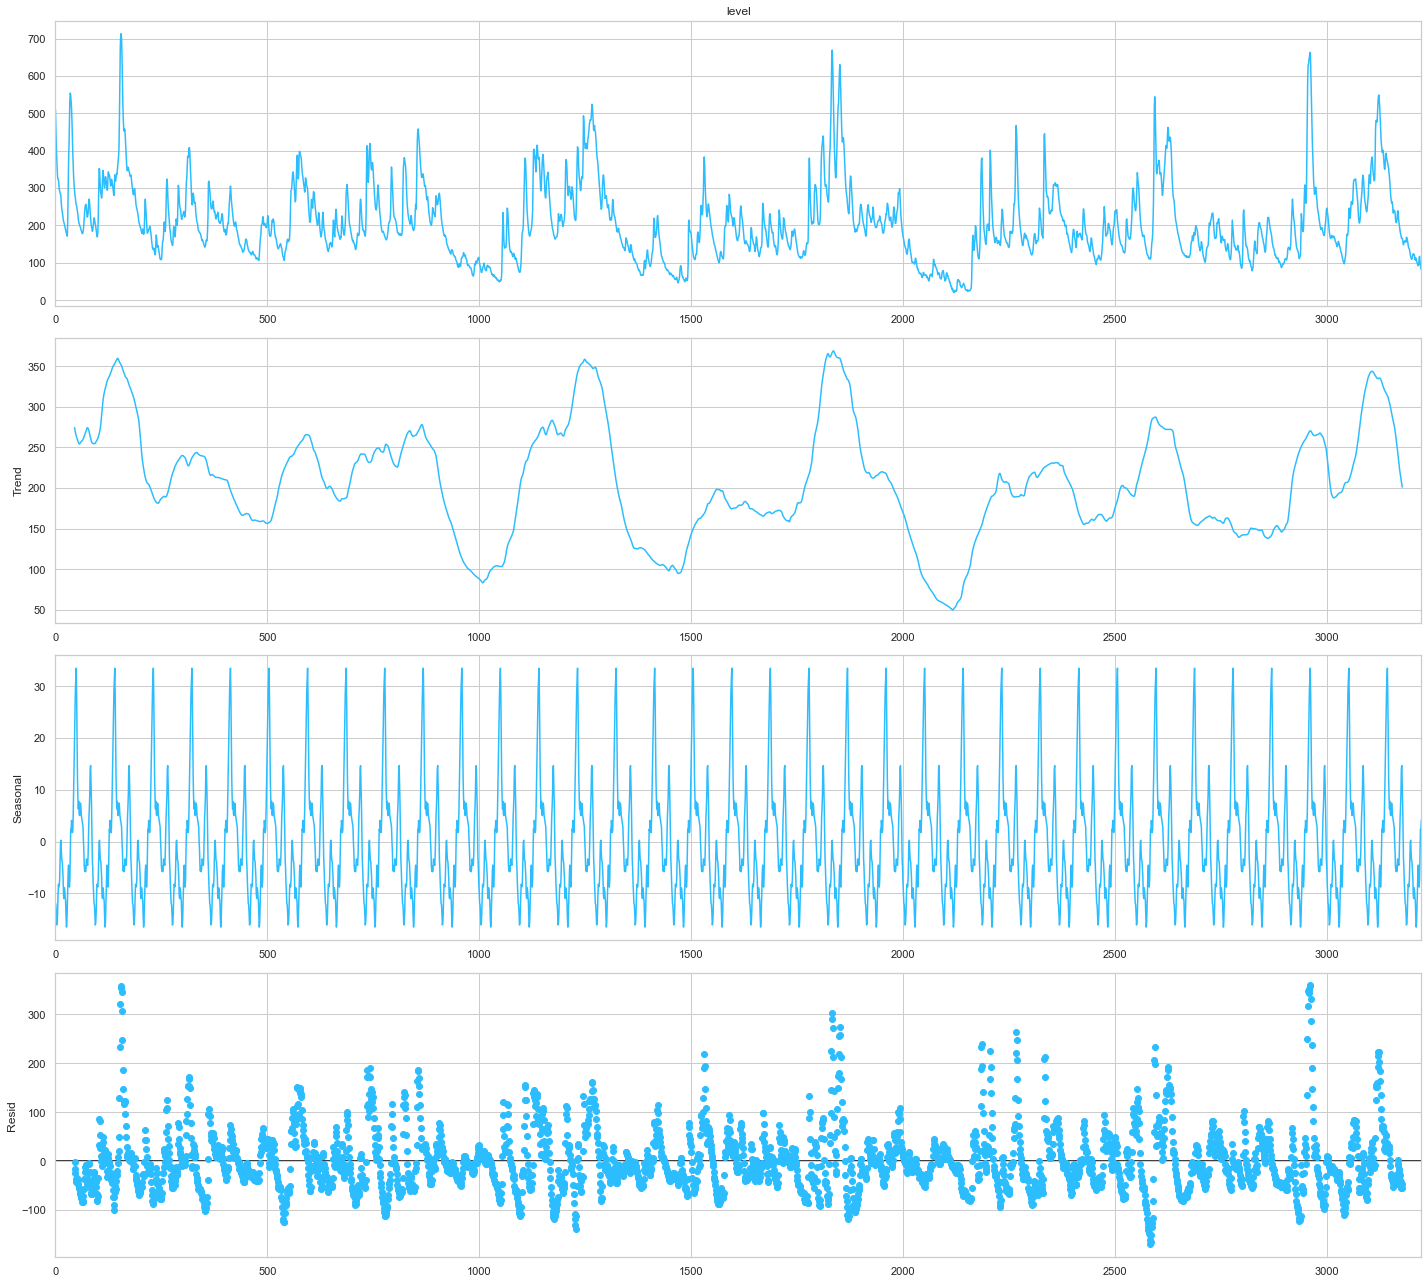

In [234]:
plt.rc("figure", figsize=(20,18))
result_add.plot()
plt.show()

Show distribution of data by using a Box Plot. The Box shows the quartiles of the dataset, the whiskers show the rest of the distribution

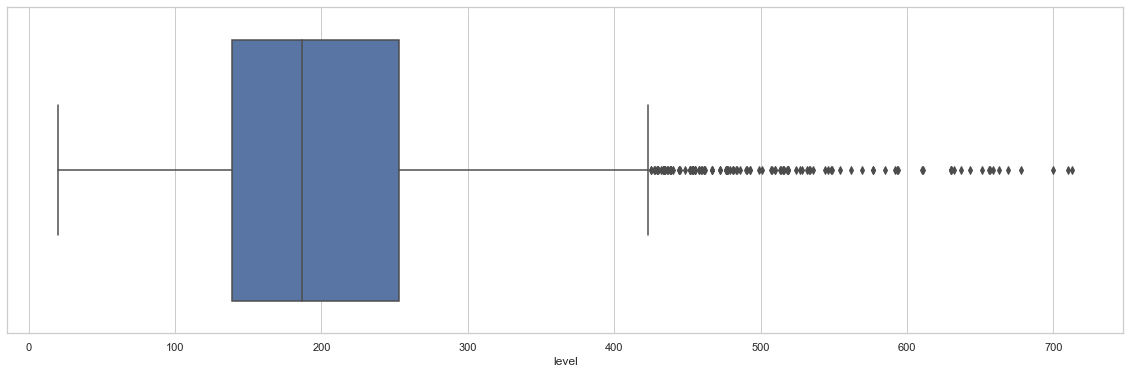

In [235]:
plt.figure(2, figsize=(20,6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data['level'])


In [236]:
print(data)

            date  level
0     2013-01-01    510
1     2013-01-02    461
2     2013-01-03    414
3     2013-01-04    378
4     2013-01-05    351
...          ...    ...
3219  2021-10-23    117
3220  2021-10-24    105
3221  2021-10-25     93
3222  2021-10-26     85
3223  2021-10-27     82

[3224 rows x 2 columns]


The Box Plot shows, that while most of the time, the rhine water level is at around 120 to 250, the level sometimes rises thrice the size of the average.

Split data according to months in order to see the variation in water levels per month since intuitively, the month is of great concern when looking at water levels

In [237]:
def split_data_monthly(data):
    monthly_data = data.copy()
    monthly_data['month'] = pd.DatetimeIndex(data['date']).month_name()
    monthly_median = monthly_data.groupby('month').agg(
        {'level': np.median}).reset_index()
    monthly_mean = monthly_data.groupby('month').agg({'level': np.mean}).reset_index()
    return monthly_mean, monthly_median

monthly_mean, monthly_median = split_data_monthly(data)
print(monthly_mean)

        month       level
0       April  186.607407
1      August  179.949821
2    December  180.883534
3    February  279.236220
4     January  237.659498
5        July  222.978495
6        June  267.440741
7       March  227.985663
8         May  248.232975
9    November  164.493776
10    October  132.585455
11  September  146.259259


Sorts the months in the right order for the plot later on

In [238]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

monthly_mean['month'] = pd.Categorical(monthly_mean['month'], categories=months, ordered=True)
monthly_median['month'] = pd.Categorical(monthly_median['month'], categories=months, ordered=True)

        month       level
0       April  186.607407
1      August  179.949821
2    December  180.883534
3    February  279.236220
4     January  237.659498
5        July  222.978495
6        June  267.440741
7       March  227.985663
8         May  248.232975
9    November  164.493776
10    October  132.585455
11  September  146.259259


[Text(0.5, 1.0, 'Mean of Rhine Water Levels per Month')]

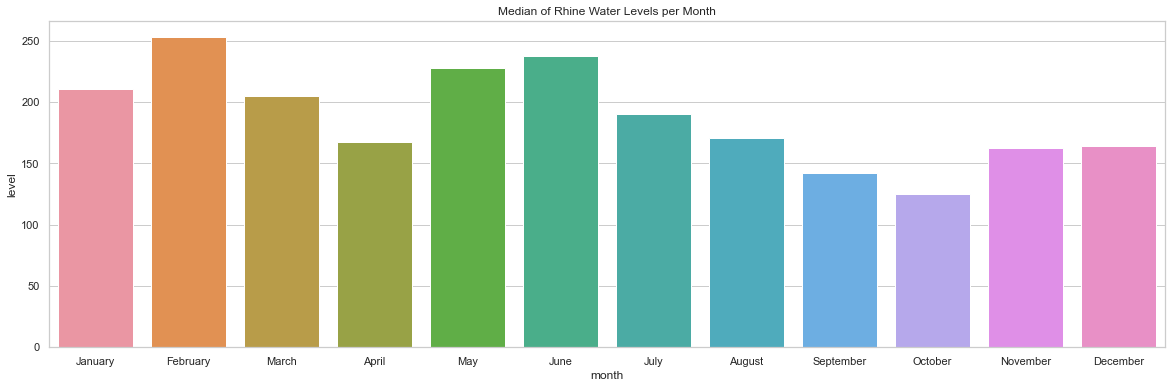

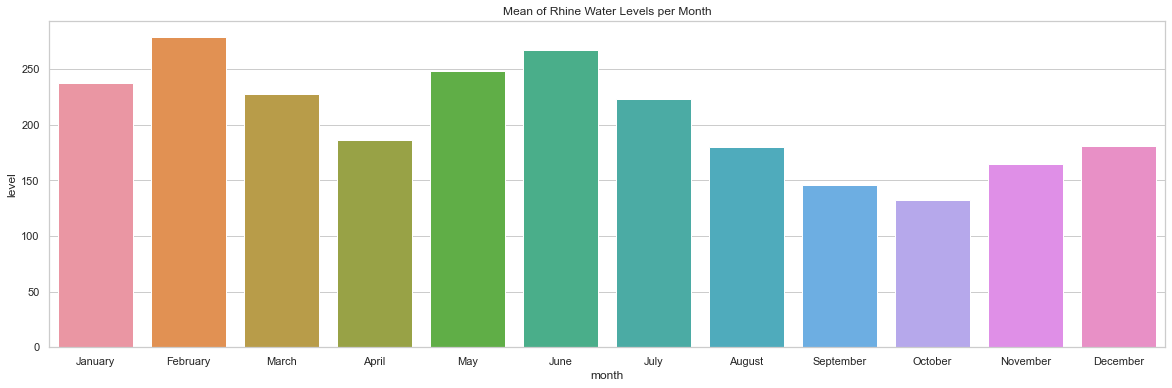

In [239]:
plt.figure(3, figsize=(20,6))
sns.barplot(x="month", y="level", data=monthly_median).set(title='Median of Rhine Water Levels per Month')
plt.figure(4, figsize=(20,6))
sns.barplot(x="month", y="level", data=monthly_mean).set(title='Mean of Rhine Water Levels per Month')




In [240]:
quantile1, quantile3 = data['level'].quantile([0.25, 0.75])
IQR = quantile3 - quantile1
lower = quantile1 - (1.5 * IQR)
upper = quantile3 + (1.5 * IQR)
outlier = []
for level in data['level']:
    if level < lower or level > upper:
        outlier.append(level)

print('We have {} outlier in our data from a total of {} data points. \nThat makes {}% of the data outliers'.format(
    len(outlier), len(data['level']), round(len(outlier) / len(data['level']) * 100, 3)))





We have 122 outlier in our data from a total of 3224 data points. 
That makes 3.784% of the data outliers


Next: 
- Look at the change of the water levels after years when looking only at one month.

- (Use interpolation for outliers?)

- Use Seasonal Autoregressive Integrated Moving Average (SARIMA) or LSTMs